# Engine Predictive Maintenance Analytics

This notebook loads the NASA C MAPSS FD001 dataset (Kaggle version), 
performs preprocessing, builds baseline and improved predictive models, 
and exports predictions and metrics for the Streamlit dashboard app.

### Objectives

* The primary objective of the notebook is to predict the Remaining Useful Life (RUL) of a Turbo Fan Engine using Data Analytics and Machine Learning.
* The secondary objectives are to use the dataset to answer a number of businness questions and hypotheses by exploring three data analytics categories: descriptive analytics, diagnostic analytics and predictive analytics.
* Write your notebook objective here, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling" (**remove**)

### Inputs

* The notebook uses a subset (FD001) of the NASA CMAPSS (Commercial Modular Aero Propulsion System Simulation) Turbo Fan Engine Degradation dataset (Kaggle version) to build a predictive maintenance model capable of estimating the Remaining Useful Life (RUL) of engines based on sensor data collected over time.  The FD001 subset is one of four subsets of the dataset, with each subset representing a different engine but of the same class.
* Write down which data or information you need to run the notebook (**remove**)

### Outputs

* The notebook exports predictions and metrics for the Streamlit dashboard app
* Code, plots and a predictive model were writen, ploted and built at various stages of the notebook
* Write here which files, code or artefacts you generate by the end of the notebook (**remove**) 

### Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. (**remove later**)



---

### Import Important Libraries

* All the important libraries needed for the project have been loaded to the virtual environment (.venv).
* The libraries used for the project are listed in the requirement.txt file

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)

---

### Load Dataset

* This loads the dataset on to the Jupyter Notebook
* Data Set: FD001
  - Train trjectories: 100
  - Test trajectories: 100
  - Conditions: ONE (Sea Level)
  - Fault Modes: ONE (HPC Degradation) 
  - Dataset subsets:
    - train_FD001.txt
    - test_FD001.txt
    - RUL_FD001.txt
    - x.txt

In [3]:
# The Kaggle dataset files are space separated with trailing empty columns
# The following function loads the FD001 files into pandas DataFrame
# The files have no header row, so column names were added using the metadata provided on Kaggle

def load_fd001(data_dir="data"):
    col_names = [
        "engine_id", "cycle",
        "op_setting_1", "op_setting_2", "op_setting_3"
    ] + [f"sensor_{i}" for i in range(1, 22)]

    df_train = pd.read_csv(
        f"../{data_dir}/train_FD001.txt",
        sep=r"\s+",
        header=None,
        names=col_names
    )

    df_test = pd.read_csv(
        f"../{data_dir}/test_FD001.txt",
        sep=r"\s+",
        header=None,
        names=col_names
    )

    df_rul = pd.read_csv(
        f"../{data_dir}/RUL_FD001.txt",
        sep=r"\s+",
        header=None,
        names=["RUL"]
    )

    return df_train, df_test, df_rul
df_train, df_test, df_rul = load_fd001()

df_train.head(), df_test.head(), df_rul.head()





(   engine_id  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_1  \
 0          1      1       -0.0007       -0.0004         100.0    518.67   
 1          1      2        0.0019       -0.0003         100.0    518.67   
 2          1      3       -0.0043        0.0003         100.0    518.67   
 3          1      4        0.0007        0.0000         100.0    518.67   
 4          1      5       -0.0019       -0.0002         100.0    518.67   
 
    sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  sensor_8  \
 0    641.82   1589.70   1400.60     14.62     21.61    554.36   2388.06   
 1    642.15   1591.82   1403.14     14.62     21.61    553.75   2388.04   
 2    642.35   1587.99   1404.20     14.62     21.61    554.26   2388.08   
 3    642.35   1582.79   1401.87     14.62     21.61    554.45   2388.11   
 4    642.37   1582.85   1406.22     14.62     21.61    554.00   2388.06   
 
    sensor_9  sensor_10  sensor_11  sensor_12  sensor_13  sensor_14  sensor_15  \
 0

---

### Exploratory Data Analysis - EDA

* The following cells conduct a number of EDA steps to understand, clean and prepare the data for data analytics

In [4]:
# Display dataset shapes and basic info
print("Training data shape:", df_train.shape)
print("Testing data shape:", df_test.shape)
print("RUL data shape:", df_rul.shape)





Training data shape: (20631, 26)
Testing data shape: (13096, 26)
RUL data shape: (100, 1)


In [6]:
# Display basic information about the training data
print("Training Data Info:")
print(df_train.info())
print("\nTraining Data Head:")
print(df_train.head())
print("\nTraining Data Description:")
print(df_train.describe())
print("\nTraining Data Missing Values:")
print(df_train.isnull().sum())
print("\n" + "="*50 + "\n")

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   engine_id     20631 non-null  int64  
 1   cycle         20631 non-null  int64  
 2   op_setting_1  20631 non-null  float64
 3   op_setting_2  20631 non-null  float64
 4   op_setting_3  20631 non-null  float64
 5   sensor_1      20631 non-null  float64
 6   sensor_2      20631 non-null  float64
 7   sensor_3      20631 non-null  float64
 8   sensor_4      20631 non-null  float64
 9   sensor_5      20631 non-null  float64
 10  sensor_6      20631 non-null  float64
 11  sensor_7      20631 non-null  float64
 12  sensor_8      20631 non-null  float64
 13  sensor_9      20631 non-null  float64
 14  sensor_10     20631 non-null  float64
 15  sensor_11     20631 non-null  float64
 16  sensor_12     20631 non-null  float64
 17  sensor_13     20631 non-null  float64
 18  sensor

In [7]:
# Display basic information about the test data
print("Test Data Info:")
print(df_test.info())
print("\nTest Data Head:")
print(df_test.head())
print("\nTest Data Description:")
print(df_test.describe())
print("\nTest Data Missing Values:")
print(df_test.isnull().sum())
print("\n" + "="*50 + "\n")

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   engine_id     13096 non-null  int64  
 1   cycle         13096 non-null  int64  
 2   op_setting_1  13096 non-null  float64
 3   op_setting_2  13096 non-null  float64
 4   op_setting_3  13096 non-null  float64
 5   sensor_1      13096 non-null  float64
 6   sensor_2      13096 non-null  float64
 7   sensor_3      13096 non-null  float64
 8   sensor_4      13096 non-null  float64
 9   sensor_5      13096 non-null  float64
 10  sensor_6      13096 non-null  float64
 11  sensor_7      13096 non-null  float64
 12  sensor_8      13096 non-null  float64
 13  sensor_9      13096 non-null  float64
 14  sensor_10     13096 non-null  float64
 15  sensor_11     13096 non-null  float64
 16  sensor_12     13096 non-null  float64
 17  sensor_13     13096 non-null  float64
 18  sensor_14 

In [8]:
# Display basic information about the RUL data
print("RUL Data Info:")
print(df_rul.info())    
print("\nRUL Data Head:")
print(df_rul.head())
print("\nRUL Data Description:")
print(df_rul.describe())
print("\nRUL Data Missing Values:")
print(df_rul.isnull().sum())

RUL Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   RUL     100 non-null    int64
dtypes: int64(1)
memory usage: 932.0 bytes
None

RUL Data Head:
   RUL
0  112
1   98
2   69
3   82
4   91

RUL Data Description:
             RUL
count  100.00000
mean    75.52000
std     41.76497
min      7.00000
25%     32.75000
50%     86.00000
75%    112.25000
max    145.00000

RUL Data Missing Values:
RUL    0
dtype: int64


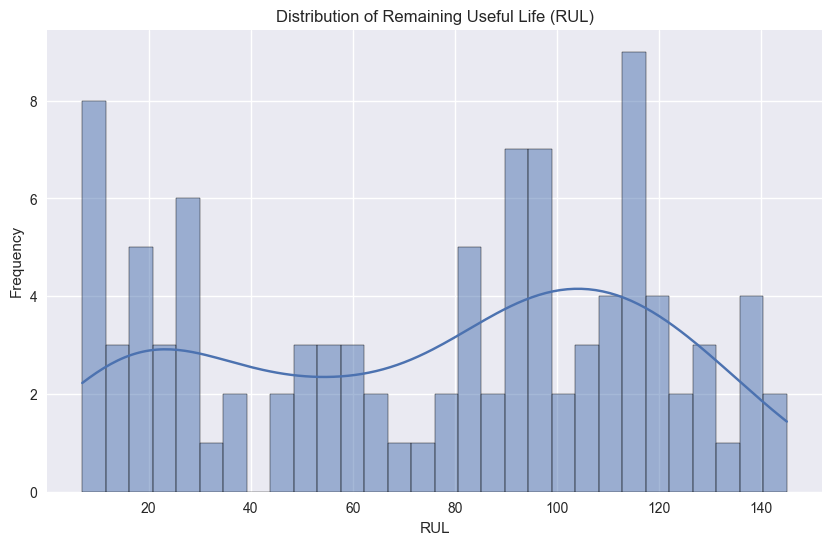

In [11]:
## Visualize the distribution of RUL values
plt.figure(figsize=(10, 6))
sns.histplot(df_rul['RUL'], bins=30, kde=True)
plt.title('Distribution of Remaining Useful Life (RUL)')
plt.xlabel('RUL')
plt.ylabel('Frequency')
plt.show()




In [9]:
# Create RUL column for training data
rul_train = df_train.groupby("engine_id")["cycle"].max().reset_index()
rul_train.columns = ["engine_id", "max_cycle"]
df_train = df_train.merge(rul_train, on="engine_id", how="left")
df_train["RUL"] = df_train["max_cycle"] - df_train["cycle"]
df_train.drop("max_cycle", axis=1, inplace=True)
print("Training data with RUL:")
print(df_train.head())


Training data with RUL:
   engine_id  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_1  \
0          1      1       -0.0007       -0.0004         100.0    518.67   
1          1      2        0.0019       -0.0003         100.0    518.67   
2          1      3       -0.0043        0.0003         100.0    518.67   
3          1      4        0.0007        0.0000         100.0    518.67   
4          1      5       -0.0019       -0.0002         100.0    518.67   

   sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  sensor_8  \
0    641.82   1589.70   1400.60     14.62     21.61    554.36   2388.06   
1    642.15   1591.82   1403.14     14.62     21.61    553.75   2388.04   
2    642.35   1587.99   1404.20     14.62     21.61    554.26   2388.08   
3    642.35   1582.79   1401.87     14.62     21.61    554.45   2388.11   
4    642.37   1582.85   1406.22     14.62     21.61    554.00   2388.06   

   sensor_9  sensor_10  sensor_11  sensor_12  sensor_13  sensor_14  sensor

In [10]:
# Prepare test data with RUL
rul_test = df_test.groupby("engine_id")["cycle"].max().reset_index()
rul_test.columns = ["engine_id", "max_cycle"]
df_test = df_test.merge(rul_test, on="engine_id", how="left")
df_test["RUL"] = df_rul["RUL"]
df_test["RUL"] = df_test["RUL"] + (df_test["max_cycle"] - df_test["cycle"])
df_test.drop("max_cycle", axis=1, inplace=True)
print("Testing data with RUL:")
print(df_test.head())

Testing data with RUL:
   engine_id  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_1  \
0          1      1        0.0023        0.0003         100.0    518.67   
1          1      2       -0.0027       -0.0003         100.0    518.67   
2          1      3        0.0003        0.0001         100.0    518.67   
3          1      4        0.0042        0.0000         100.0    518.67   
4          1      5        0.0014        0.0000         100.0    518.67   

   sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  sensor_8  \
0    643.02   1585.29   1398.21     14.62     21.61    553.90   2388.04   
1    641.71   1588.45   1395.42     14.62     21.61    554.85   2388.01   
2    642.46   1586.94   1401.34     14.62     21.61    554.11   2388.05   
3    642.44   1584.12   1406.42     14.62     21.61    554.07   2388.03   
4    642.51   1587.19   1401.92     14.62     21.61    554.16   2388.01   

   sensor_9  sensor_10  sensor_11  sensor_12  sensor_13  sensor_14  sensor_

In [12]:
# Sensor statistics
sensor_stats = df_train.iloc[:, 2:22].describe().T
print("Sensor statistics:")
print(sensor_stats)

Sensor statistics:
                count         mean           std        min        25%  \
op_setting_1  20631.0    -0.000009  2.187313e-03    -0.0087    -0.0015   
op_setting_2  20631.0     0.000002  2.930621e-04    -0.0006    -0.0002   
op_setting_3  20631.0   100.000000  0.000000e+00   100.0000   100.0000   
sensor_1      20631.0   518.670000  0.000000e+00   518.6700   518.6700   
sensor_2      20631.0   642.680934  5.000533e-01   641.2100   642.3250   
sensor_3      20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600   
sensor_4      20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600   
sensor_5      20631.0    14.620000  1.776400e-15    14.6200    14.6200   
sensor_6      20631.0    21.609803  1.388985e-03    21.6000    21.6100   
sensor_7      20631.0   553.367711  8.850923e-01   549.8500   552.8100   
sensor_8      20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500   
sensor_9      20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000   
sensor_10     20631

**Key findings:**

The dataset looks clean.  The datatypes are correct. There are no missing values, except for the missing columns, which were created in the earlier step using the metadata privided NASA CPASS.  The empty columns between the values were removed as the data was loaded.  Some sensors (1, 5, 10, 16, 18 and 19) have very low standard deviation and are therefore not considered as important features. They are probably just noise.  A Remaining Useful Life (RUL) labels were created using max cycle per engine minus current cycle to explore sensor behaviour with visualisations.



---

### Data Visualisation

* The following cells use a number of data visualisation libraries to plot a number of visualisations that attempt to answer a number of business questions or prove some of our hypotheses.

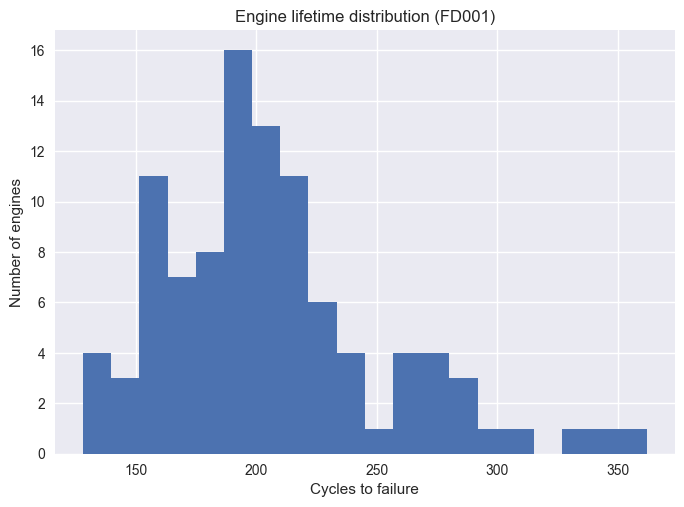

In [14]:
# Engine lifetime distribution:
    
engine_life = df_train.groupby("engine_id")["cycle"].max()
engine_life.hist(bins=20)
plt.xlabel("Cycles to failure")
plt.ylabel("Number of engines")
plt.title("Engine lifetime distribution (FD001)")
plt.show()


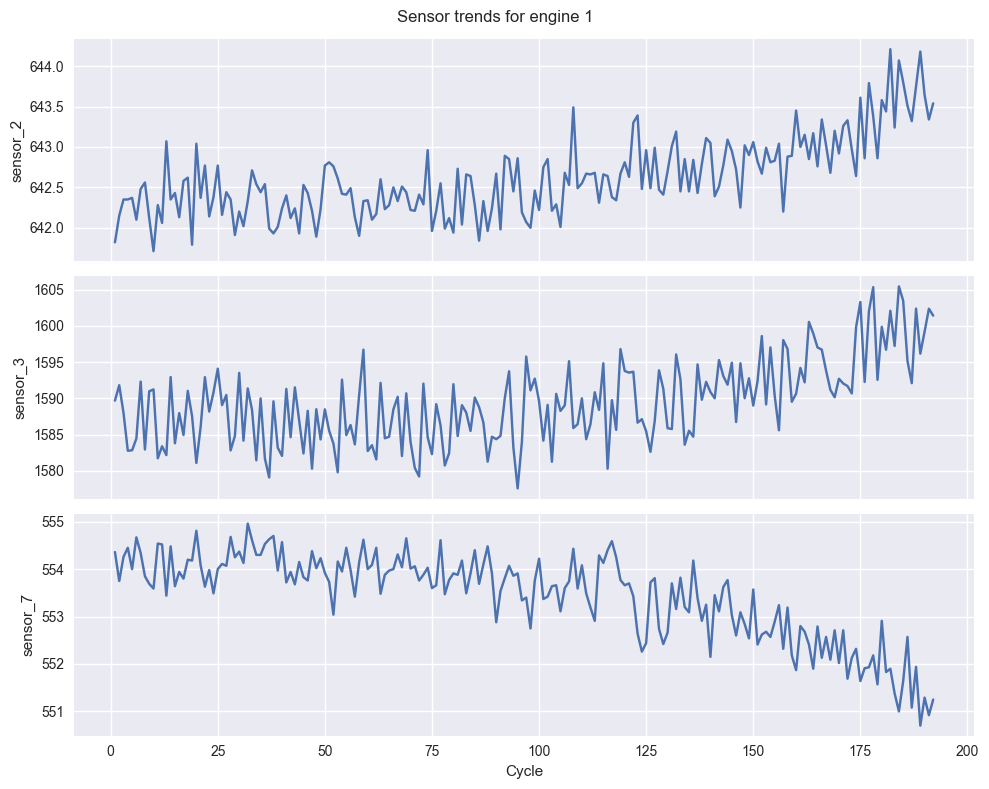

In [15]:
# Sensor trend for a sample engine:

sample_engine = 1
sample_cols = ["sensor_2", "sensor_3", "sensor_7"]

fig, ax = plt.subplots(len(sample_cols), 1, figsize=(10, 8), sharex=True)
for i, col in enumerate(sample_cols):
    subset = df_train[df_train["engine_id"] == sample_engine]
    ax[i].plot(subset["cycle"], subset[col])
    ax[i].set_ylabel(col)
ax[-1].set_xlabel("Cycle")
plt.suptitle(f"Sensor trends for engine {sample_engine}")
plt.tight_layout()
plt.show()

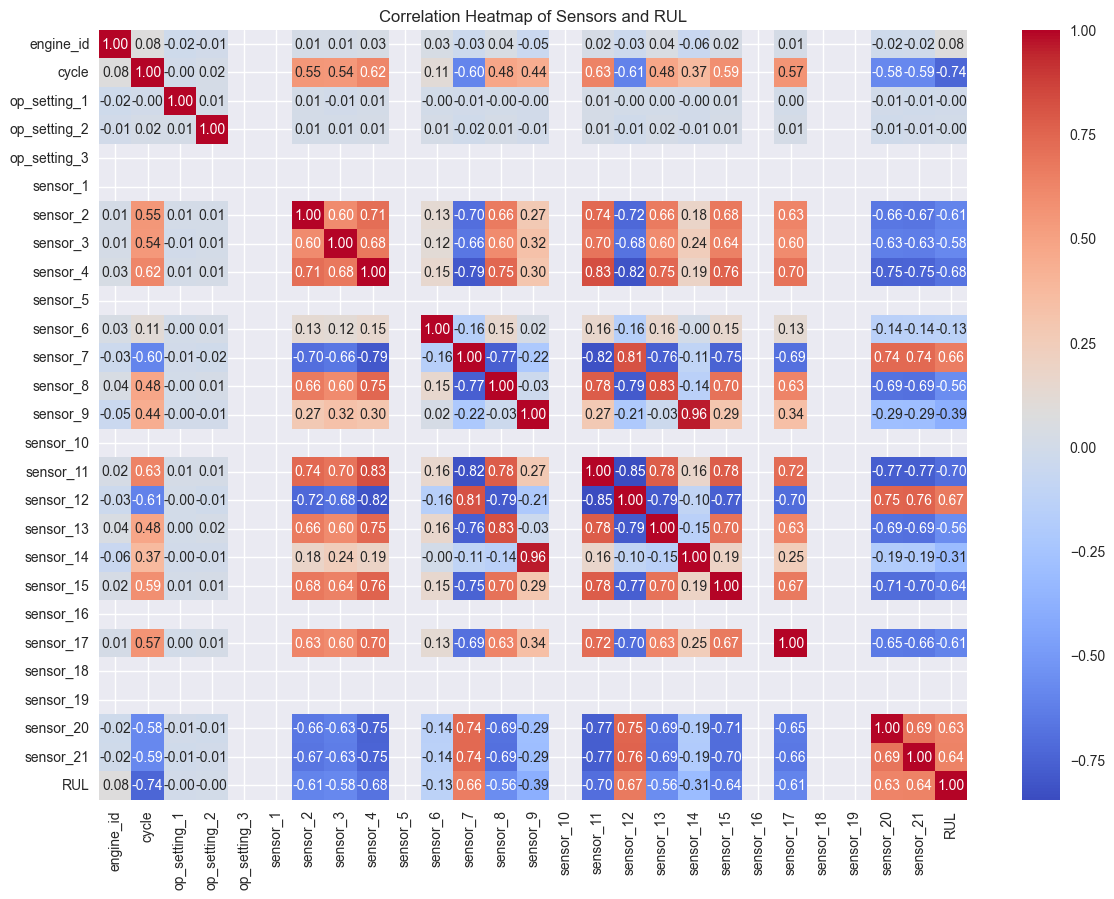

In [17]:
# Correlation heatmap of sensors and RUL
plt.figure(figsize=(14, 10))
corr = df_train.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Sensors and RUL") 
plt.show()

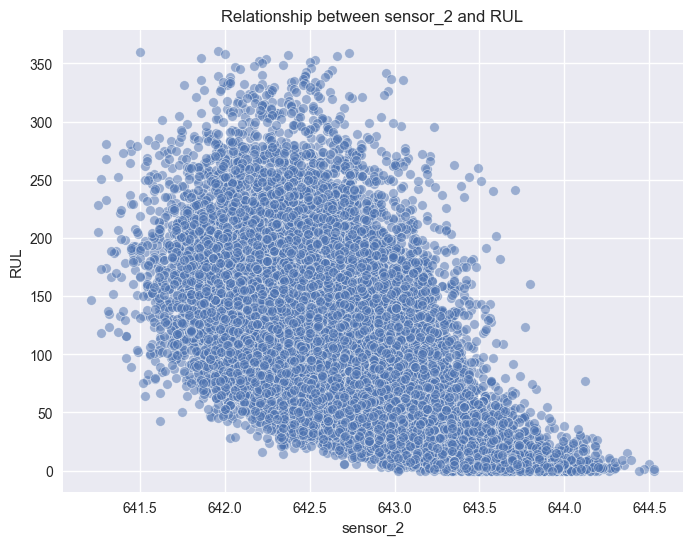

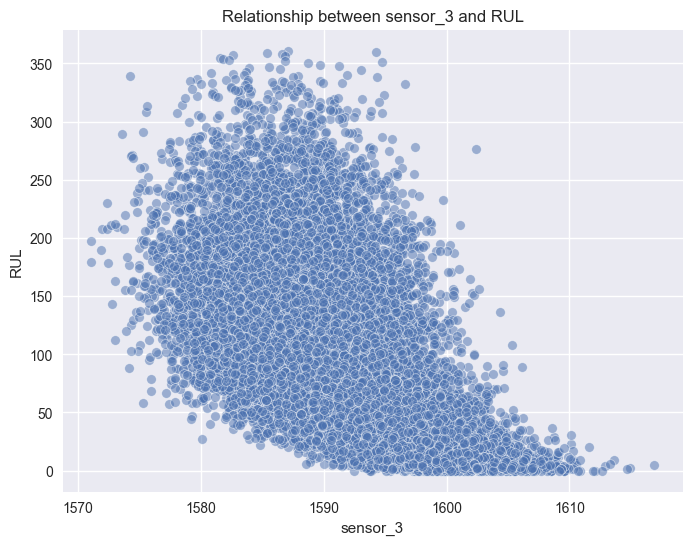

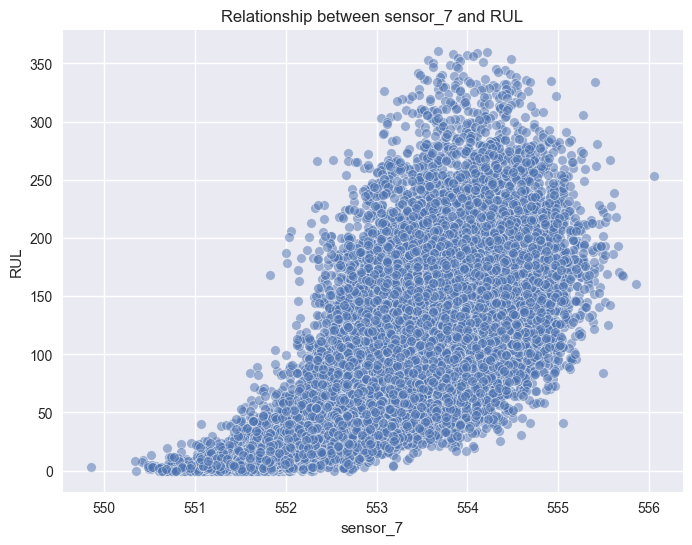

In [23]:
# Visualize relationship between selected sensors and RUL using scatter plots
selected_sensors = ["sensor_2", "sensor_3", "sensor_7"]
for sensor in selected_sensors:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_train, x=sensor, y="RUL", alpha=0.5)
    plt.title(f"Relationship between {sensor} and RUL")
    plt.xlabel(sensor)
    plt.ylabel("RUL")
    plt.show()
    


---

### Descriptive Analytics

* The following cells conduct a number of descriptive analytics on the dataset

---

### Diagnostic Analytics

* The following cells conduct a number of diagnostic analytics on the dataset

---

### Feature Engineering, Selection and Scaling

* The following cells conduct Feature Engineering, Feature Selection and Feature Scaling to prepare the data for predictive analytics

---

In [26]:
# Feature Engineering and Selection
# We will drop irrelevant sensors based on variance and correlation analysis

importance_scores = corr["RUL"].abs().sort_values(ascending=False)
print("Feature importance based on correlation with RUL:")
print(importance_scores)

Feature importance based on correlation with RUL:
RUL             1.000000
cycle           0.736241
sensor_11       0.696228
sensor_4        0.678948
sensor_12       0.671983
sensor_7        0.657223
sensor_15       0.642667
sensor_21       0.635662
sensor_20       0.629428
sensor_2        0.606484
sensor_17       0.606154
sensor_3        0.584520
sensor_8        0.563968
sensor_13       0.562569
sensor_9        0.390102
sensor_14       0.306769
sensor_6        0.128348
engine_id       0.078753
op_setting_1    0.003198
op_setting_2    0.001948
op_setting_3         NaN
sensor_1             NaN
sensor_5             NaN
sensor_10            NaN
sensor_16            NaN
sensor_18            NaN
sensor_19            NaN
Name: RUL, dtype: float64


In [28]:
# print the relevant sensors to keep
relevant_sensors = importance_scores[importance_scores > 0.1].index.tolist()
relevant_sensors.remove("RUL")  # Remove target variable
print("Relevant sensors based on correlation threshold:")
print(relevant_sensors)



Relevant sensors based on correlation threshold:
['cycle', 'sensor_11', 'sensor_4', 'sensor_12', 'sensor_7', 'sensor_15', 'sensor_21', 'sensor_20', 'sensor_2', 'sensor_17', 'sensor_3', 'sensor_8', 'sensor_13', 'sensor_9', 'sensor_14', 'sensor_6']


In [29]:
# Prepare training and testing datasets
X_train = df_train[relevant_sensors]
y_train = df_train["RUL"]
X_test = df_test[relevant_sensors]
y_test = df_test["RUL"] 

In [30]:
# Standardize features with StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Predictive Analytics

* The following cells perform predictive maintenance analytics on a NASA Turbofan Engine 
* Remaining Useful Live (RUL) is used as target for the model training

In [31]:
# Split training data into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)


In [32]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_final, y_train_final)

RandomForestRegressor(random_state=42)

In [45]:
# Evaluate on validation set
y_val_pred = rf_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
val_mae = mean_absolute_error(y_val, y_val_pred)
print(f"Validation MSE: {val_mse:.2f}, RMSE: {val_rmse:.2f}, MAE: {val_mae:.2f}")

Validation MSE: 1292.54, RMSE: 35.95, MAE: 25.43


In [40]:
y_test_null_drop = y_test.dropna()
X_test_null_drop = X_test_scaled[y_test.notnull()]
# Evaluate on test set
y_test_pred = rf_model.predict(X_test_null_drop)
test_rmse = mean_squared_error(y_test_null_drop, y_test_pred, squared=False)
test_mse = mean_squared_error(y_test_null_drop, y_test_pred)
test_mae = mean_absolute_error(y_test_null_drop, y_test_pred)
print(f"Test MSE: {test_mse:.2f}, Test RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}")


Test MSE: 8000.20, Test RMSE: 89.44, MAE: 79.20


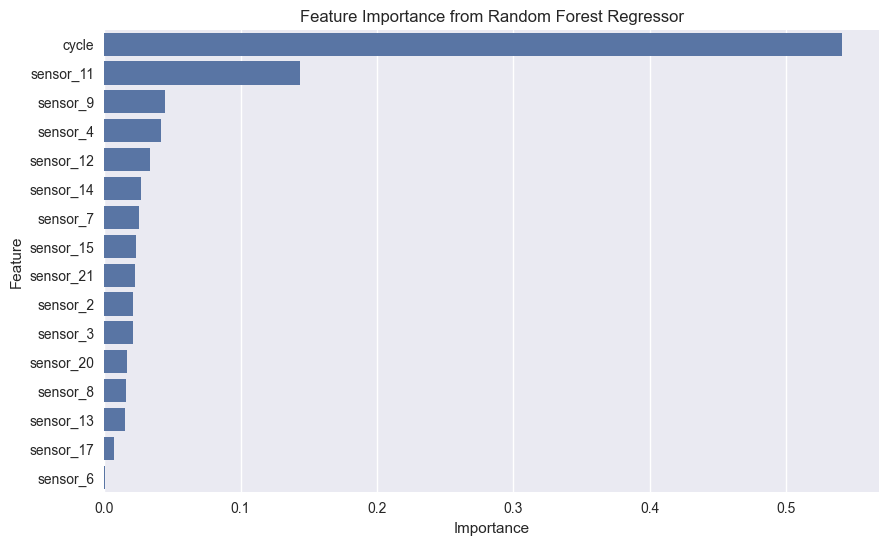

In [46]:
# Visualize feature importance
feature_importances = rf_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Feature Importance from Random Forest Regressor")
plt.show()

In [41]:
# Train Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_final, y_train_final)

GradientBoostingRegressor(random_state=42)

In [42]:
# Evaluate on validation set
y_val_pred_gb = gb_model.predict(X_val)
val_mse_gb = mean_squared_error(y_val, y_val_pred_gb)
val_rmse_gb = mean_squared_error(y_val, y_val_pred_gb, squared=False)
val_mae_gb = mean_absolute_error(y_val, y_val_pred_gb)
print(f"Gradient Boosting Validation MSE: {val_mse_gb:.2f}, RMSE: {val_rmse_gb:.2f}, MAE: {val_mae_gb:.2f}")

Gradient Boosting Validation MSE: 1273.16, RMSE: 35.68, MAE: 25.52


In [44]:
# Evaluate on test set
y_test_pred_gb = gb_model.predict(X_test_null_drop)   
test_mse_gb = mean_squared_error(y_test_null_drop, y_test_pred_gb)
test_rmse_gb = mean_squared_error(y_test_null_drop, y_test_pred_gb, squared=False)
test_mae_gb = mean_absolute_error(y_test_null_drop, y_test_pred_gb)
print(f"Gradient Boosting Test MSE: {test_mse_gb:.2f}, RMSE: {test_rmse_gb:.2f}, MAE: {test_mae_gb:.2f}")

Gradient Boosting Test MSE: 7934.11, RMSE: 89.07, MAE: 78.75


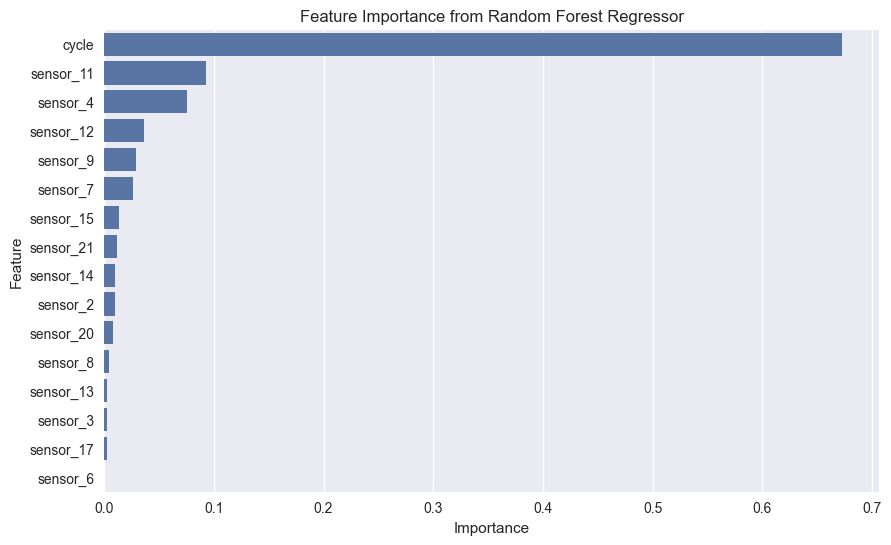

In [48]:
# Visualize feature importance
feature_importances = gb_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Feature Importance from Random Forest Regressor")
plt.show()

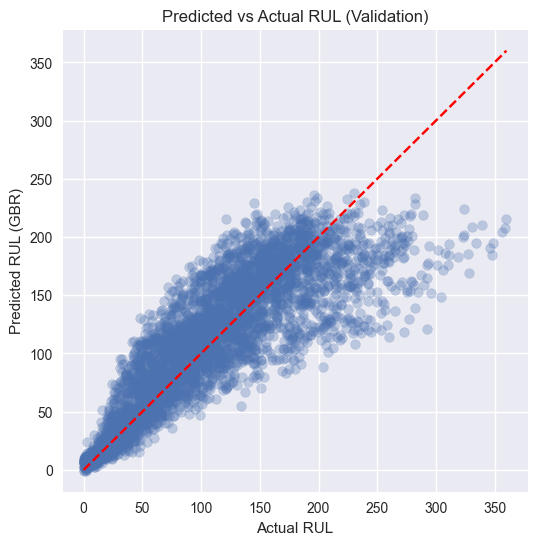

In [49]:
# Evaluation & plots
# Let's gather metrics for both models on validation set
# Compare models:

rmse_rf = val_rmse
rmse_gbr = val_rmse_gb
mae_rf = val_mae
mae_gbr = val_mae_gb

metrics = pd.DataFrame({
    "Model": ["RandomForest", "GradientBoosting"],
    "RMSE": [rmse_rf, rmse_gbr],
    "MAE": [mae_rf, mae_gbr]
})
metrics

# predicted vs actual (validation) for Gradient Boosting Regressor:

plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_val_pred_gb, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "r--")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL (GBR)")
plt.title("Predicted vs Actual RUL (Validation)")
plt.show()

In [58]:
# Export predictions & metrics for Streamlit Dashboard
# Test set predictions (for rul_predictions_fd001.csv):

test_pred_gbr = gb_model.predict(X_test_scaled)

rul_predictions = df_test[["engine_id", "cycle"]].copy()
rul_predictions["true_rul"] = y_test.values
rul_predictions["pred_rul"] = test_pred_gbr

# Include sensors for diagnostics page
for col in features:
    rul_predictions[col] = df_test[col].values

rul_predictions.head()
rul_predictions.to_csv("../data/rul_predictions_fd001.csv", index=False)

# Model metrics (for model_metrics.csv):
# Here we evaluate on the test set as well:

test_pred_rf = rf_model.predict(X_test_null_drop)

rmse_rf_test = mean_squared_error(y_test_null_drop, test_pred_rf, squared=False)
mae_rf_test = mean_absolute_error(y_test_null_drop, test_pred_rf)

test_pred_gbr = gb_model.predict(X_test_null_drop)

rmse_gbr_test = mean_squared_error(y_test_null_drop, test_pred_gbr, squared=False)
mae_gbr_test = mean_absolute_error(y_test_null_drop, test_pred_gbr)

metrics_test = pd.DataFrame({
    "Model": ["RandomForest", "GradientBoosting"],
    "RMSE": [rmse_rf_test, rmse_gbr_test],
    "MAE": [mae_rf_test, mae_gbr_test]
})
metrics_test
metrics_test.to_csv("../data/model_metrics.csv", index=False)

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\User\\Documents\\Sarkima\\Sarki\\MyEducation\\MyCourses\\CodeInstitute\\DataAnalytics\\VSCode\\predictive-maintenance-project\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\User\\Documents\\Sarkima\\Sarki\\MyEducation\\MyCourses\\CodeInstitute\\DataAnalytics\\VSCode\\predictive-maintenance-project'

# Section 1

Section 1 content

---

# Section 2

Section 2 content

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* In cases where you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create your folder here
  # os.makedirs(name='')
except Exception as e:
  print(e)
